In [1]:
# Import packages
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import anderson
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.compat import lzip

In [6]:
# Load the dataset
df = pd.read_csv('data/customer_data.csv')
df.columns

Index(['id', 'age', 'gender', 'income', 'education', 'region',
       'loyalty_status', 'purchase_frequency', 'purchase_amount',
       'product_category', 'promotion_usage', 'satisfaction_score'],
      dtype='object')

In [9]:
# Convert Categorical columns to the Category datatype
categorical_columns = ['gender', 'education', 'region', 'loyalty_status', 'purchase_frequency',
                       'product_category', 'promotion_usage']

# For each column... convert to category
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Convert ID to String since it won't be used in the analysis
df['id'] = df['id'].astype(str)

# Confirm columns were converted
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   id                  100000 non-null  object  
 1   age                 100000 non-null  int64   
 2   gender              100000 non-null  category
 3   income              100000 non-null  int64   
 4   education           100000 non-null  category
 5   region              100000 non-null  category
 6   loyalty_status      100000 non-null  category
 7   purchase_frequency  100000 non-null  category
 8   purchase_amount     100000 non-null  int64   
 9   product_category    100000 non-null  category
 10  promotion_usage     100000 non-null  category
 11  satisfaction_score  100000 non-null  int64   
dtypes: category(7), int64(4), object(1)
memory usage: 4.5+ MB


# Check for Null Values

In [11]:
# Loop through each column and print value counts
for column in df.columns:
    print(df[column].value_counts(dropna=False))
    print("\n")

1         1
66651     1
66673     1
66672     1
66671     1
         ..
33332     1
33331     1
33330     1
33329     1
100000    1
Name: id, Length: 100000, dtype: int64


30    8867
31    8645
29    8636
28    8266
32    8034
33    7214
27    7022
34    5894
26    5882
35    4873
25    4856
36    3583
24    3576
37    2697
23    2636
38    1791
22    1790
39    1200
21    1187
20     743
40     682
41     481
19     457
42     242
18     233
17     143
43     125
16      66
44      58
15      39
45      35
47      13
14      13
46      11
13       4
12       3
48       2
49       1
Name: age, dtype: int64


Female    50074
Male      49926
Name: gender, dtype: int64


39596    12
28944    10
12803    10
36828    10
21832     9
         ..
47076     1
44614     1
14934     1
45093     1
35207     1
Name: income, Length: 40003, dtype: int64


College       39874
Bachelor      30279
HighSchool    20031
Masters        9816
Name: education, dtype: int64


East     30074
West     29935
Sout

# Check for Duplicates

In [13]:
# Check for complete duplicates
if df.duplicated().any():
    print('Has complete duplicates')
else:
    print('No complete duplicates')

No complete duplicates


# Check for Outliers

In [14]:
# Drop ID column since we don't need it for this analysis
df = df.drop(columns='id')

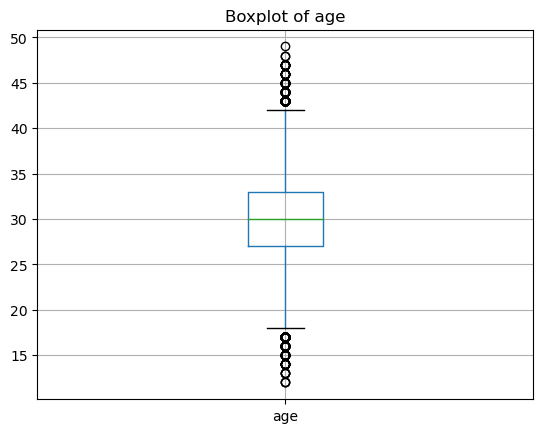

age has 513 outliers


Value counts for gender
Female    50074
Male      49926
Name: gender, dtype: int64




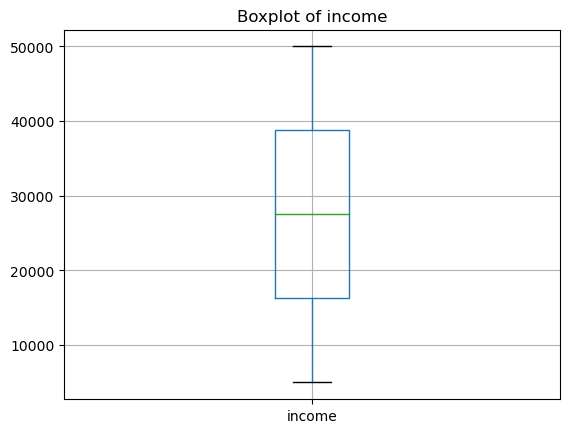

income has 0 outliers


Value counts for education
College       39874
Bachelor      30279
HighSchool    20031
Masters        9816
Name: education, dtype: int64



Value counts for region
East     30074
West     29935
South    20073
North    19918
Name: region, dtype: int64



Value counts for loyalty_status
Regular    60138
Silver     29964
Gold        9898
Name: loyalty_status, dtype: int64



Value counts for purchase_frequency
rare          50019
occasional    29886
frequent      20095
Name: purchase_frequency, dtype: int64




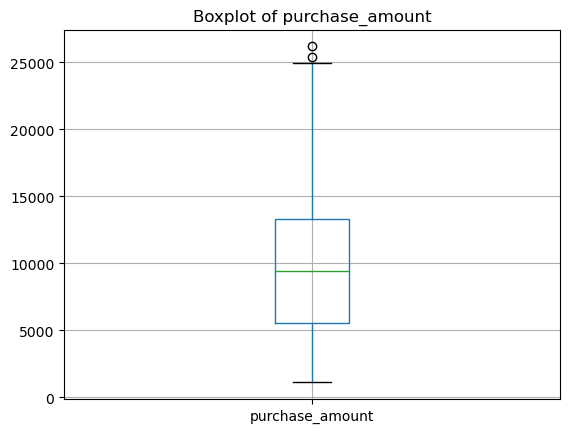

purchase_amount has 2 outliers


Value counts for product_category
Electronics    30027
Clothing       19989
Books          14925
Food           14822
Health         10123
Home            5079
Beauty          5035
Name: product_category, dtype: int64



Value counts for promotion_usage
0    69920
1    30080
Name: promotion_usage, dtype: int64




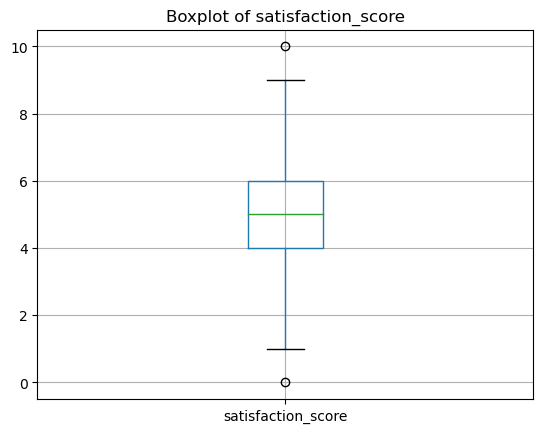

satisfaction_score has 2 outliers



In [15]:
# Create boxplot and if outliers exist, calculate using IQR method
for col in df.columns:
    if df[col].dtype != 'category':
        # Create boxplot
        df.boxplot(column=col)
        plt.title(f'Boxplot of {col}')
        plt.show()
        
        # Calculate IQR lower and upper bounds to determine outliers
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count and display outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        num_outliers = outliers.shape[0]
        print(f"{col} has {num_outliers} outliers")
        print()
        
        
    else:
        # For categorical variables, determine if any category makes up a small percentage
        print()
        print(f'Value counts for {col}')
        print(df[col].value_counts())
        print('\n')